## CNN pour tout station

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers ,optimizers,models,regularizers
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from codecarbon import EmissionsTracker
import logging

code carbon

In [31]:
tracker = EmissionsTracker(
    project_name="cnn_window_glissant",
    log_level=logging.INFO,
    output_file="model_cnn_window_glissant.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=5,
    allow_multiple_runs=True 
)

[codecarbon WARNING @ 10:34:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:34:16] [setup] RAM Tracking...
[codecarbon INFO @ 10:34:16] [setup] CPU Tracking...
[codecarbon WARNING @ 10:34:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU



[codecarbon INFO @ 10:34:18] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
[codecarbon INFO @ 10:34:18] [setup] GPU Tracking...
[codecarbon INFO @ 10:34:18] No GPU found.
[codecarbon INFO @ 10:34:18] >>> Tracker's metadata:
[codecarbon INFO @ 10:34:18]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 10:34:18]   Python version: 3.8.5
[codecarbon INFO @ 10:34:18]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 10:34:18]   Available RAM : 15.852 GB
[codecarbon INFO @ 10:34:18]   CPU count: 8
[codecarbon INFO @ 10:34:18]   CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
[codecarbon INFO @ 10:34:18]   GPU count: None
[codecarbon INFO @ 10:34:18]   GPU model: None
[codecarbon INFO @ 10:34:18] Saving emissions data to file d:\CODE\code_python\integre\cnn\5SDBDproject\emissions\model_cnn_window_glissant.csv


In [32]:
file_path = 'merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['timestamp']).astype('int64') 
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data=data.sort_values('timestamp')
print(data.columns.to_list())
feature_to_normaliser=['bike_stands','available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events']
other_features = [col for col in data.columns if col not in feature_to_normaliser]
new_column_order=feature_to_normaliser+other_features
data=data[new_column_order]
print(data.columns.to_list())
num_features_to_normalize=len(feature_to_normaliser)

['timestamp', 'number', 'status', 'available_bike_stands', 'available_bikes', 'bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'wind_speed', 'counter_events', 'day_of_week', 'is_weekend']
['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'available_bikes', 'is_rainy', 'day_of_week', 'is_weekend']


Normaliser

In [33]:
### verifier ordonne
data[:5]

,bike_stands,available_bike_stands,visibility_distance,current_temperature,feels_like_temperature,wind_speed,counter_events,timestamp,number,status,available_bikes,is_rainy,day_of_week,is_weekend
0,20,7,10000.0,6.99,6.17,5.54,0,1733940000000000000,259,1,13,0.0,2,0
870608,16,11,10000.0,6.99,6.17,5.54,0,1733940000000000000,257,1,5,0.0,2,0
869769,13,2,10000.0,6.99,6.17,5.54,0,1733940000000000000,309,1,10,0.0,2,0
869768,17,16,10000.0,6.99,6.17,5.54,0,1733940000000000000,207,1,1,0.0,2,0
868965,22,5,10000.0,6.99,6.17,5.54,0,1733940000000000000,126,1,17,0.0,2,0


In [34]:
X = data.drop(columns=['available_bikes']).values  
y = data['available_bikes'].values 
## test et train
split_index = int(0.8 * len(X))  
X_train_raw, X_test_raw = X[:split_index], X[split_index:]
y_train_raw, y_test_raw = y[:split_index], y[split_index:]
scaler_X = StandardScaler()
X_train_to_normalize = X_train_raw[:, :num_features_to_normalize]
X_train_not_to_normalize = X_train_raw[:, num_features_to_normalize:]
X_train_feature_normalized = scaler_X.fit_transform(X_train_to_normalize)

X_test_to_normalize = X_test_raw[:, :num_features_to_normalize]
X_test_not_to_normalize = X_test_raw[:, num_features_to_normalize:]
X_test_to_feature_normalized = scaler_X.transform(X_test_to_normalize)

X_train = np.hstack([X_train_feature_normalized, X_train_not_to_normalize])
X_test = np.hstack([X_test_to_feature_normalized, X_test_not_to_normalize])

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()
print("\n x train shape:",X_train.shape)
print("\n x test shape:",X_test.shape)
print("\n y train shape:",y_train.shape)
print("\n y test shape:",y_test.shape)


 x train shape: (950319, 13)

 x test shape: (237580, 13)

 y train shape: (950319,)

 y test shape: (237580,)


window glissant

In [35]:
station_column_index = list(data.drop(columns='available_bikes').columns).index('number')

print(station_column_index)
station_ids = X[:, station_column_index]
print(station_ids)
unique_stations = np.unique(station_ids)
print(len(unique_stations))

8
[259. 257. 309. ... 265.  65. 396.]
382


In [36]:
def create_sliding_window_grouped(X, y, station_ids, time_steps):
    X_seq_all, y_seq_all, station_seq_all = [], [], []
    unique_stations = np.unique(station_ids)

    for station in unique_stations:
        station_indices = np.where(station_ids == station)[0]
        X_station = X[station_indices]
        y_station = y[station_indices]
        for i in range(len(X_station) - time_steps):
            X_window = np.hstack([X_station[i:i + time_steps], y_station[i:i + time_steps].reshape(-1, 1)])
            X_seq_all.append(X_window)
            y_seq_all.append(y_station[i + time_steps])
            station_seq_all.append(station)

    return np.array(X_seq_all), np.array(y_seq_all), np.array(station_seq_all)
time_steps=4
X_train_seq, y_train_seq, station_train_seq = create_sliding_window_grouped(X_train, y_train, station_ids[:split_index], time_steps)
X_test_seq, y_test_seq, station_test_seq = create_sliding_window_grouped(X_test, y_test, station_ids[split_index:], time_steps)

print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("station_train_seq shape:", station_train_seq.shape)

print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("station_test_seq shape:", station_test_seq.shape)


train data:
X_train_seq shape: (948791, 4, 14)
y_train_seq shape: (948791,)
station_train_seq shape: (948791,)

test data:
X_test_seq shape: (236056, 4, 14)
y_test_seq shape: (236056,)
station_test_seq shape: (236056,)


model cnn

verifier data tranning

In [37]:
print(data.drop(columns='available_bikes').columns.to_list())
print(X_train_seq[1])
print(y_train_seq[1])
print(station_train_seq[1])

['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'is_rainy', 'day_of_week', 'is_weekend']
[[ 1.72191139e-01 -1.03536827e+00  6.01042690e-01 -5.99491337e-02
   1.07119318e-01 -6.82358561e-01  2.39245755e+00  1.73394090e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.72958431e+00]
 [ 1.72191139e-01 -8.77475701e-01  6.01042690e-01 -1.34252842e-01
  -1.50572189e-02 -6.29059375e-01  2.39245755e+00  1.73394180e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.31811055e+00]
 [ 1.72191139e-01 -5.61690556e-01  6.01042690e-01 -2.08556550e-01
  -1.37233756e-01 -5.75760190e-01  2.39245755e+00  1.73394270e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  9.06636786e-01]
 [ 1.72191139e-01 -2.45905412e-01  6.01042690e-01 -2.82860258e-01
  -2.59410293e-0

In [ ]:
model = models.Sequential([
    layers.Conv1D(filters=16,  
                  kernel_size=2, 
                  activation='relu', 
                  input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l2(0.001)
                  ),  
    layers.BatchNormalization(),  
    layers.MaxPooling1D(pool_size=2, strides=1),
    layers.Dropout(0.15),
 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 16)             464       
                                                                 
 batch_normalization_4 (Bat  (None, 3, 16)             64        
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 16)             0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2, 16)             0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [39]:
val_size = int(0.6 * len(X_test_seq))
X_test_seq, X_val = X_test_seq[:val_size], X_test_seq[val_size:]
y_test_seq, y_val = y_test_seq[:val_size], y_test_seq[val_size:]
print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)

print("\nval data:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)


train data:
X_train_seq shape: (948791, 4, 14)
y_train_seq shape: (948791,)

val data:
X_val shape: (94423, 4, 14)
y_val shape: (94423,)

test data:
X_test_seq shape: (141633, 4, 14)
y_test_seq shape: (141633,)


In [45]:

from tensorflow.keras import callbacks
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]
tracker.start()
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    shuffle=True,
    callbacks=[callbacks] 
)

tracker.stop()


[codecarbon WARNING @ 12:39:04] Already started tracking


Training the model...
Epoch 1/30
14825/14825 [==============================] - 162s 11ms/step - loss: 0.9989 - mae: 0.8028 - val_loss: 7.3269 - val_mae: 2.5612 - lr: 2.0000e-04
Epoch 2/30
14825/14825 [==============================] - 156s 11ms/step - loss: 0.9981 - mae: 0.8033 - val_loss: 3.7529 - val_mae: 1.7281 - lr: 2.0000e-04
Epoch 3/30
14825/14825 [==============================] - 3286s 222ms/step - loss: 0.9980 - mae: 0.8033 - val_loss: 16.6396 - val_mae: 3.9842 - lr: 2.0000e-04
Epoch 4/30
14825/14825 [==============================] - 34s 2ms/step - loss: 0.9979 - mae: 0.8033 - val_loss: 15.9098 - val_mae: 3.8916 - lr: 2.0000e-04
Epoch 5/30
14825/14825 [==============================] - 58s 4ms/step - loss: 0.9977 - mae: 0.8031 - val_loss: 1.0098 - val_mae: 0.8501 - lr: 4.0000e-05
Epoch 6/30
14825/14825 [==============================] - 60s 4ms/step - loss: 0.9976 - mae: 0.8031 - val_loss: 8.1791 - val_mae: 2.7228 - lr: 4.0000e-05
Epoch 7/30
14825/14825 [====================

[codecarbon WARNING @ 13:50:52] Tracker already stopped !
[codecarbon WARNING @ 13:50:52] Background scheduler didn't run for a long period (11512s), results might be inaccurate
[codecarbon INFO @ 13:50:52] Energy consumed for RAM : 0.019428 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 13:50:52] Energy consumed for all CPUs : 0.045760 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 13:50:52] 0.065189 kWh of electricity used since the beginning.


0.003653101879602851

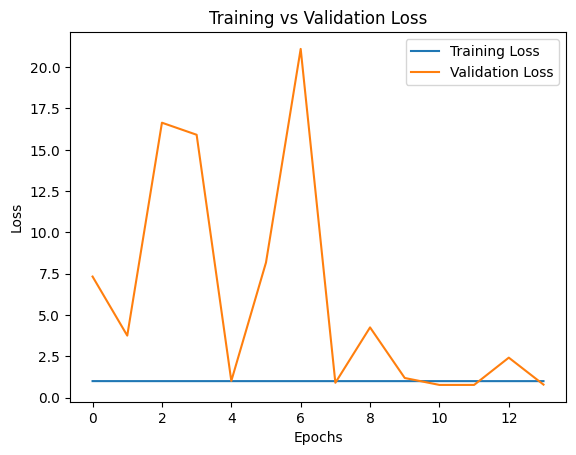

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [47]:
def taux_correct_predictions(y_test,y_pred,tolerance):
    correct_predictions = np.abs(y_test - y_pred) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  
    print(f"Le taux de précision correctes de test avec tolerance={tolerance}: {accuracy:.2f}%")
predictions = model.predict(X_test_seq)
predictions = np.round(predictions).astype(int)
# Calcul des métriques pour l'ensemble de test
mse = mean_squared_error(y_test_seq, predictions)
mae = mean_absolute_error(y_test_seq, predictions)
r2 = r2_score(y_test_seq, predictions)
y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

taux_correct_predictions(y_test,predictions,0)
taux_correct_predictions(y_test,predictions,1)
taux_correct_predictions(y_test,predictions,2)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

4427/4427 [==============================] - 8s 2ms/step
Le taux de précision correctes de test avec tolerance=0: 0.00%
Le taux de précision correctes de test avec tolerance=1: 10.51%
Le taux de précision correctes de test avec tolerance=2: 21.12%
MSE: 1.2603, MAE: 0.9435, R²: -0.0310


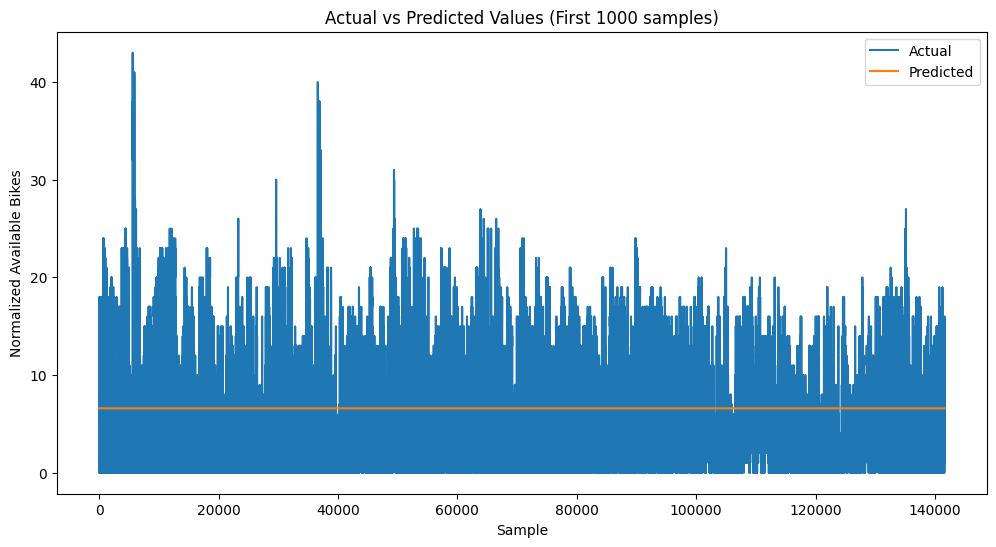

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values (First 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()